# What is Fastai?
If you're not familiar with the list of frameworks and libraries that exist for Deep Learning - or even if you are - then you might not be aware of [Fastai](https://www.fast.ai). This is both a Deep Learning Framework built on top of Pytorch as well as an online curriculum to quickly become productive using Deep Learning for your own interests. Jeremy is a very solid teacher and I recommend taking the course if you're interested in learning how this all works. And, I don't mean that simply because I like the lectures but also because [I've taken them before](https://github.com/Shoklan/Youtube/tree/master/fastai2020) and I've also built my own simple projects out of the lectures done by him - and Rachel since she's also assisting with building the course. One really big plus for this course is that you'll start by actually building a model and using it: in this version it will be **Birds** vs **Forests** instead of **Cats** vs **Dogs** like used to be. As Jeremy points out in the first lecture, most people don't learn in an academic way. By that we mean they start with theory and then learn how to interact with the system. Instead, we learn a few basic ideas and then toss ourselves in to apply and learn as we go.

## So, What Am I Going to Do?
Lately, I've been playing a game called [**The Cycle: Frontier**](https://store.steampowered.com/app/868270/The_Cycle_Frontier/) which is a kind of *Extraction Shooter* game. What this means is that players are dropped into a semi-persistent server to collect items, kill creatures and even kill other players. Really, it is up to the player to decide how they interact with and play the game.
But being a shooter means that there are guns - and since there are guns there are categories of guns. Since fantasy is inspired by the real world in some sense, the question I would like to ask is **Knowing Models are Derived from the Real World Weapons, can we build a classifier based on real life weapons that can correctly predict Fantasy Weapons**?

This post, like the lectures, is not going to be about how this all works but instead is going to be a simple application and retrospective. That being said, let's start!
We'll start with the important imports for getting this working.

In [32]:
import os
from pathlib import Path
from time import sleep


from duckduckgo_search import ddg_images # Will write more about this later.
from fastdownload import download_url    # Will need to explore this more.

from fastcore.all import *
from fastai.vision.all import *     # This is for the CNN learner.
from fastai.vision.widgets import * # This is required for the cleaner later.

The first three imports you should hopefully be familiar with. Everything else you should simply grant for now.

In [3]:
# This is a function from the notebook:
def search_images(term, max_images=200):
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [4]:
urls = search_images('assult rifle photos', max_images=1)
urls[0]

'http://allhdwallpapers.com/wp-content/uploads/2016/07/Assault-Rifle-5.jpg'

So, we're going to download an example image using the helper functions so far and make sure its working:

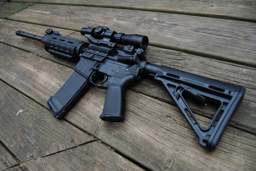

In [53]:
dest = Path('..', '__data', 'example-ar-gun.png')
download_url(urls[0], dest, show_progress=False)

im = Image.open(dest)
im.to_thumb(256,256)

Now let's check for a DMR and make sure that is sane:

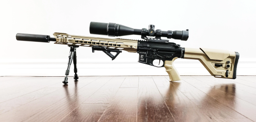

In [55]:
dmrUrls = search_images('dmr photos', max_images=1)
dest = Path('..', '__data', 'example-dmr-gun.png')
download_url(dmrUrls[0], dest, show_progress=False)

im = Image.open(dest).to_thumb(256,256)
im

So, now we need data from the Internet:

In [11]:
searches = 'assault rifle','dmr'
path = Path('..', '__data', 'ar_or_dmr')

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server and blocking responses
    resize_images(path/o, max_size=400, dest=path/o)

/usr/lib/python3.10/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


The below just checks to make sure that the downloaded images are in fact images. And, then we're iterating though the results to remove what are failed images:

In [12]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

4

 We can even check the source code using `??` and see for ourselves that is what it is doing:

In [57]:
??verify_images

Signature: verify_images(fns)
Docstring: Find images in `fns` that can't be opened
Source:   
def verify_image(fn):
    "Confirm that `fn` can be opened"
    try:
        im = Image.open(fn)
        im.draft(im.mode, (32,32))
        im.load()
        return True
    except: return False
File:      ~/.local/lib/python3.10/site-packages/fastai/vision/utils.py
Type:      function


DataBlocks are are really good idea which is a lazy wrapper that defines how and what to do with the downloaded images in preparation for use in a model. There is more information at the docs page [here](https://docs.fast.ai/data.block.html) where you can check out other ways to use this. For now, we're following Jeremy's example and just mostly running the code as is.

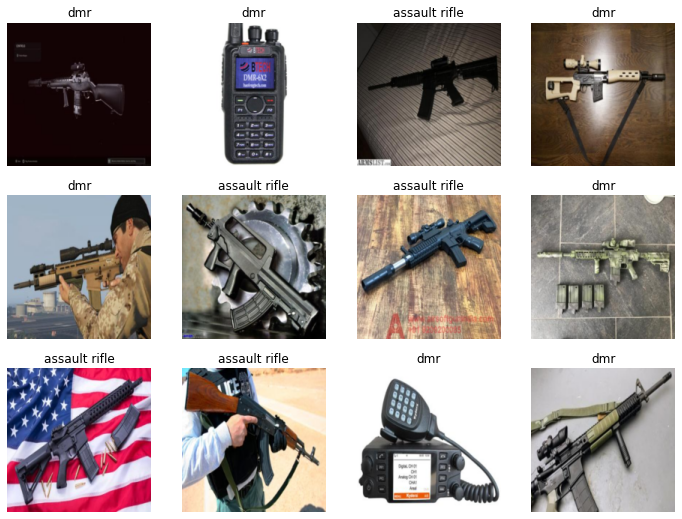

In [16]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path)

dls.show_batch(max_n=12)

Looking over some of htese images, we can already tell that we're getting images that are not what we're after. The second image in the top row is some kind radio which is not what we want. Regardless, we're again going to simply train the model even with that image in there since we're following Jeremy's advice and just going to train the model and we'll deal with the strange Radio later.

In [17]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(7)

epoch,train_loss,valid_loss,error_rate,time
0,1.135293,1.895362,0.333333,00:01


epoch,train_loss,valid_loss,error_rate,time
0,0.783494,1.115906,0.250000,00:01
1,0.578771,0.935797,0.222222,00:01
2,0.455172,0.774320,0.263889,00:01
3,0.365537,0.762151,0.263889,00:01
4,0.311685,0.737330,0.277778,00:01
5,0.263628,0.734078,0.277778,00:01
6,0.224883,0.718644,0.291667,00:01


So, this is what training will look like. The highlights are that training was very fast but  - compared to many other models trained, including Jeremy's - this one is doing pretty terrible for a Deep Learning model. The validation loss is worse than random chance which means there are very serious problems with either out Deep Learning Architecture or the data. And, the architecture is definitely not the problem so it's the data.


In [58]:
is_ar,_,probs = learn.predict(PILImage.create(Path('__data', 'example-dmr-gun.png')))
print(f"This is a(n): {is_ar}.")
print(f"Probability it's an Assult Rifle: {probs[0]:.4f}")

This is a(n): assault rifle.
Probability it's an Assult Rifle: 0.9858


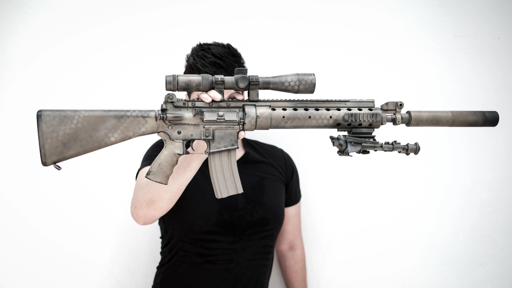

In [59]:
im = Image.open(Path('__data', 'example-dmr-gun.png')).to_thumb(512,512)
im

Big Oof. That's not an Assault Rifle.

Time to do some data cleaning. Thankfully, the Fastai library comes with a very useful function which takes the images from the data, checks what their loss is and then presents them to us so that we can remove or re-label them. Make sure you don't make the same mistake as I did and correct import the widgets: `from fastai.vision.widgets import *`

In [33]:
cleaner = ImageClassifierCleaner(learn)
cleaner

Don't forget once you've actually ran and collected what changes you want made, you'll need actually run the below code to actually make those corrections:

In [34]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

While trying to train this, I found that I was having issues unless I re-built the Data Loader so that's what we're doing here:

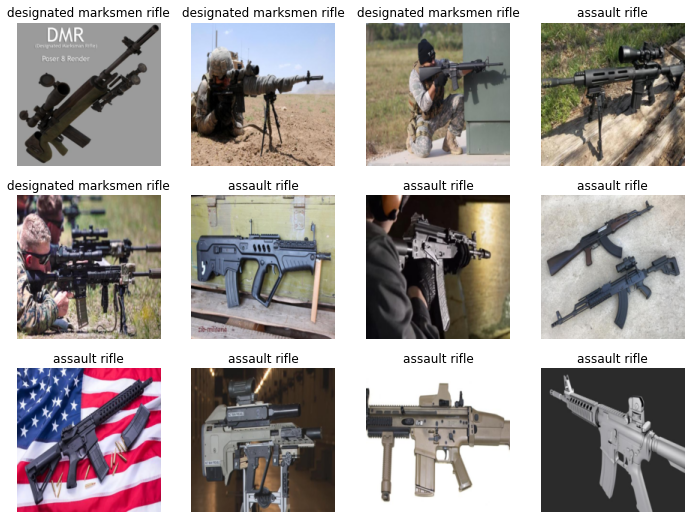

In [96]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path)

dls.show_batch(max_n=12)

Got some weird stuff again. Looks like some bikes as well as some other equipment that I don't know. That would imply that using dmr is a bad search term for what we're after.
We'll do one more training attempt to see how much harm those are doing and then we'll consider correcting the search terms.

In [97]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(7)

epoch,train_loss,valid_loss,error_rate,time
0,1.281920,1.533394,0.413333,00:02


epoch,train_loss,valid_loss,error_rate,time
0,0.869596,0.949424,0.306667,00:02
1,0.667905,0.852354,0.266667,00:02
2,0.529514,0.767100,0.213333,00:02
3,0.418889,0.783195,0.213333,00:01
4,0.338373,0.754332,0.226667,00:02
5,0.277043,0.730826,0.226667,00:02
6,0.237752,0.718148,0.226667,00:02


Looks like our validation loss is still struggling so it's time to update our search term from `dmr` to `designated marksmen rifle`.
Speedrun time!

In [98]:
searches = 'assault rifle','designated marksmen rifle'
path = Path('..', '__data', 'ar_or_dmr_v2')

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    resize_images(path/o, max_size=600, dest=path/o)

failed = verify_images(get_image_files(path))
failed.map(Path.unlink)

(#7) [None,None,None,None,None,None,None]

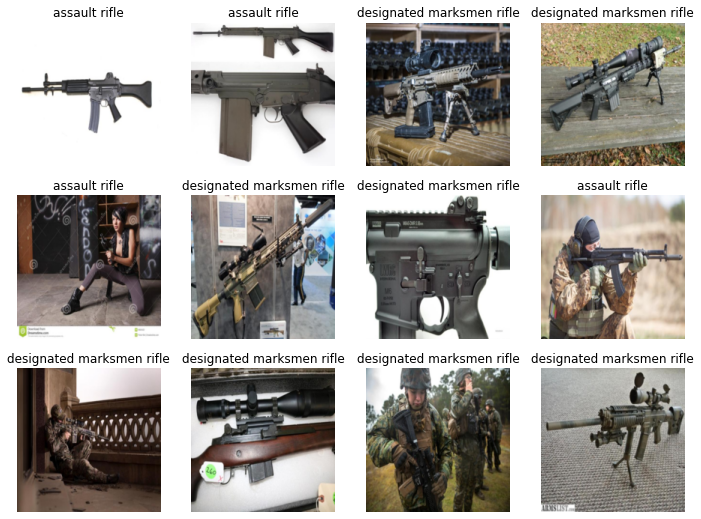

In [99]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path)

dls.show_batch(max_n=12)

In [100]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(7)

epoch,train_loss,valid_loss,error_rate,time
0,1.279173,0.758920,0.247312,00:02


epoch,train_loss,valid_loss,error_rate,time
0,0.725494,0.552330,0.215054,00:02
1,0.572957,0.452633,0.161290,00:02
2,0.429993,0.460270,0.172043,00:02
3,0.329015,0.517723,0.215054,00:02
4,0.260919,0.542659,0.215054,00:02
5,0.212036,0.543762,0.204301,00:02
6,0.176182,0.541302,0.215054,00:02


In [102]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [103]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()

In [104]:
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

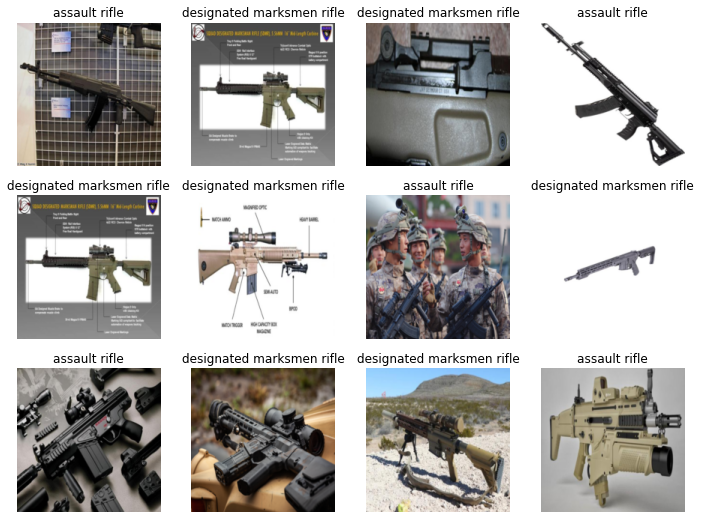

In [105]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path)

dls.show_batch(max_n=12)

In [106]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(7)

epoch,train_loss,valid_loss,error_rate,time
0,1.303078,1.055721,0.304348,00:02


epoch,train_loss,valid_loss,error_rate,time
0,0.759311,0.487650,0.250000,00:02
1,0.568219,0.461627,0.184783,00:02
2,0.444043,0.539364,0.163043,00:02
3,0.340317,0.588352,0.141304,00:02
4,0.269084,0.642941,0.152174,00:02
5,0.217371,0.619099,0.152174,00:02
6,0.183307,0.610297,0.163043,00:02


In [107]:
is_ar,_,probs = learn.predict(PILImage.create(Path('..', '__data', 'example-dmr-gun.png')))
print(f"This is a(n): {is_ar}.")
print(f"Probability it's an Assult Rifle: {probs[0]:.4f}")

This is a(n): designated marksmen rifle.
Probability it's an Assult Rifle: 0.0029


That is much better than what we were getting. Now for the real test: **Can the model tell the difference between an Assult Rifle and a DMR from the game's wiki.**


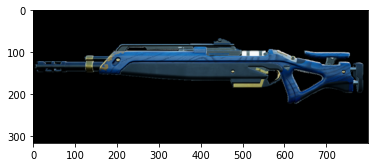

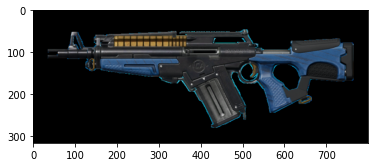

In [108]:
for image in [PILImage.create(Path('..', '__data', 'cycle-dmr-gun.png')), PILImage.create(Path('..', '__data', 'cycle-ar-gun.png'))]:
    plt.figure()
    plt.imshow(image)

In [109]:
is_ar,_,probs = learn.predict(PILImage.create(Path('..', '__data', 'cycle-dmr-gun.png')))
print(f"This is a(n): {is_ar}.")
print(f"Probability it's an Assult Rifle: {probs[0]:.4f}")

This is a(n): assault rifle.
Probability it's an Assult Rifle: 0.9968


In [110]:
is_ar,_,probs = learn.predict(PILImage.create(Path('..', '__data', 'cycle-ar-gun.png')))
print(f"This is a(n): {is_ar}.")
print(f"Probability it's an Assult Rifle: {probs[0]:.4f}")

This is a(n): assault rifle.
Probability it's an Assult Rifle: 0.9805


Looking like either I don't have enough data or I don't know enough about the domain because it is struggling to figure it out.

## Addendum
DMR also stands for [Digital Mobile Radio](https://en.wikipedia.org/wiki/Digital_mobile_radio) which is why we were getting all those weird results earlier in the post.